In [38]:
import pandas as pd

df = pd.read_csv("data/normalized-data-crop-recommendation.csv")
print(df.head())
print("Columns in dataset:", df.columns)


   Nitrogen Content  Phosphorous Content  Potassium Content  temperature  \
0          0.642857             0.264286           0.147368     0.363919   
1          0.607143             0.378571           0.136842     0.390810   
2          0.428571             0.357143           0.152632     0.428065   
3          0.528571             0.214286           0.131579     0.533328   
4          0.557143             0.264286           0.142105     0.341289   

   humidity        ph  rainfall label  
0  0.831411  0.501001  0.656458  rice  
1  0.809515  0.680005  0.741675  rice  
2  0.835548  0.948326  0.875710  rice  
3  0.807417  0.660705  0.799905  rice  
4  0.826235  0.877497  0.871231  rice  
Columns in dataset: Index(['Nitrogen Content', 'Phosphorous Content', 'Potassium Content',
       'temperature', 'humidity', 'ph', 'rainfall', 'label'],
      dtype='object')


IMPLEMENT RULE-BASED CLASSIFICATION

In [45]:
# Define Rule-Based Classifier
def rule_based_classifier(row):
    """Rule-Based Classifier for selected crops."""
    
    if row["humidity"] > 0.75 and 0.4 <= row["Nitrogen Content"] <= 0.6 and 0.5 <= row["rainfall"] <= 0.7:
        return "rice"
    
    elif row["humidity"] > 0.7 and 0.4 <= row["Nitrogen Content"] <= 0.6 and row["rainfall"] > 0.7:
        return "jute"
    
    elif 0.4 <= row["Nitrogen Content"] <= 0.6 and 0.3 <= row["Phosphorous Content"] <= 0.5 and 0.3 <= row["Potassium Content"] <= 0.5:
        return "maize"

    elif row["Nitrogen Content"] > 0.6 and row["Phosphorous Content"] < 0.3 and 6.0 <= row["ph"] <= 7.0:
        return "kidneybeans"
    
    elif row["Nitrogen Content"] < 0.4 and 0.3 <= row["Phosphorous Content"] <= 0.6 and 6.0 <= row["ph"] <= 7.5:
        return "lentil"

    elif row["humidity"] < 0.5 and row["temperature"] > 0.7 and 6.5 <= row["ph"] <= 7.5:
        return "grapes"
    
    elif row["temperature"] > 0.7 and row["Phosphorous Content"] >= 0.4 and row["rainfall"] > 0.7:
        return "watermelon"

    elif row["temperature"] > 0.7 and row["Phosphorous Content"] < 0.3 and 0.3 <= row["Potassium Content"] <= 0.6:
        return "muskmelon"
    
    elif row["temperature"] > 0.7 and row["humidity"] < 0.5 and row["Potassium Content"] > 0.6:
        return "cotton"
    
    elif 0.4 <= row["temperature"] <= 0.6 and 0.4 <= row["humidity"] <= 0.6 and 5.5 <= row["ph"] <= 6.5:
        return "coffee"
    
    else:
        return "unknown"

# Apply rule-based classification
df["Predicted_Label"] = df.apply(rule_based_classifier, axis=1)

# Display actual vs predicted labels
print("Unknown classifications:", df[df["Predicted_Label"] == "unknown"].shape[0])

print(df[["label", "Predicted_Label"]].head())


Unknown classifications: 900
  label Predicted_Label
0  rice         unknown
1  rice         unknown
2  rice            jute
3  rice            jute
4  rice            jute


MODEL PERFORMANCE

In [46]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Extract actual and predicted values
y_true = df["label"]
y_pred = df["Predicted_Label"]

# Compute metrics
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred, labels=df["label"].unique()))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="weighted", zero_division=1))
print("Recall:", recall_score(y_true, y_pred, average="weighted", zero_division=1))


Confusion Matrix:
 [[20  0  0  0  0  0  0  0 40  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [40  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]]
Accuracy: 0.02
Precision: 0.8333333333333334
Recall: 0.02


CROP DISTRIBUTION BEFORE AND AFTER PREDICTION

C:\Users\moann\AppData\Local\Temp\ipykernel_20828\4222213631.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["label"], order=df["label"].value_counts().index, palette="viridis")
C:\Users\moann\AppData\Local\Temp\ipykernel_20828\4222213631.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Predicted_Label"], order=df["Predicted_Label"].value_counts().index, palette="coolwarm")


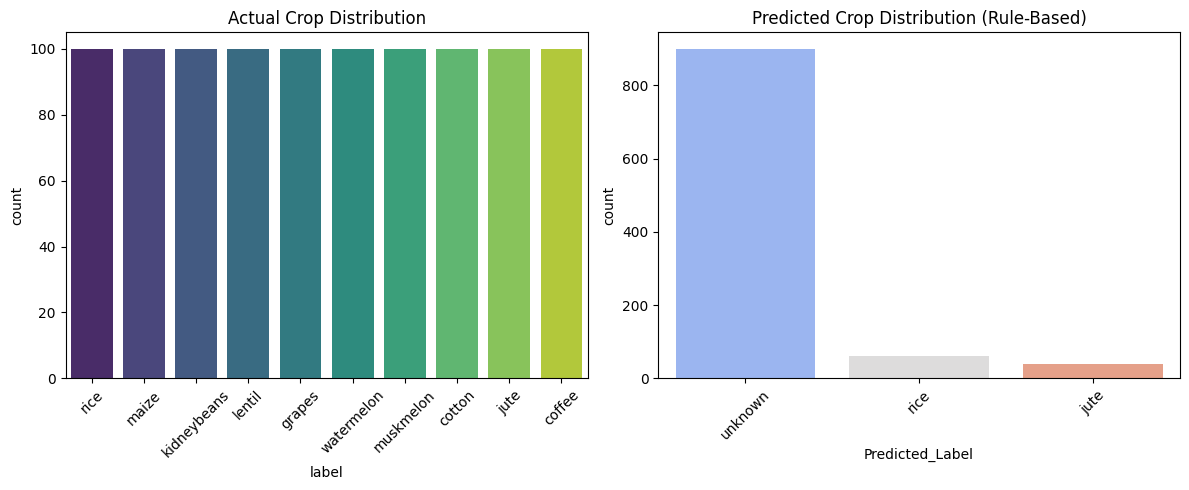

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=df["label"], order=df["label"].value_counts().index, palette="viridis")
plt.title("Actual Crop Distribution")
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
sns.countplot(x=df["Predicted_Label"], order=df["Predicted_Label"].value_counts().index, palette="coolwarm")
plt.title("Predicted Crop Distribution (Rule-Based)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


CONFUSION MATRIX HEATMAP

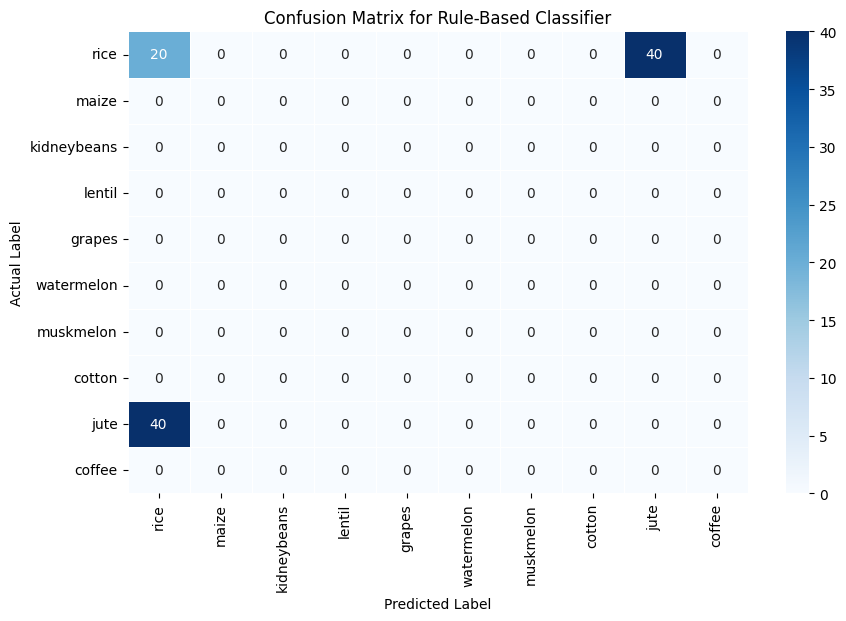

In [42]:
cm = confusion_matrix(y_true, y_pred, labels=df["label"].unique())
cm_df = pd.DataFrame(cm, index=df["label"].unique(), columns=df["label"].unique())
plt.figure(figsize=(10, 6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix for Rule-Based Classifier")
plt.show()

FEATURE RELATIONSHIP WITH CROPS

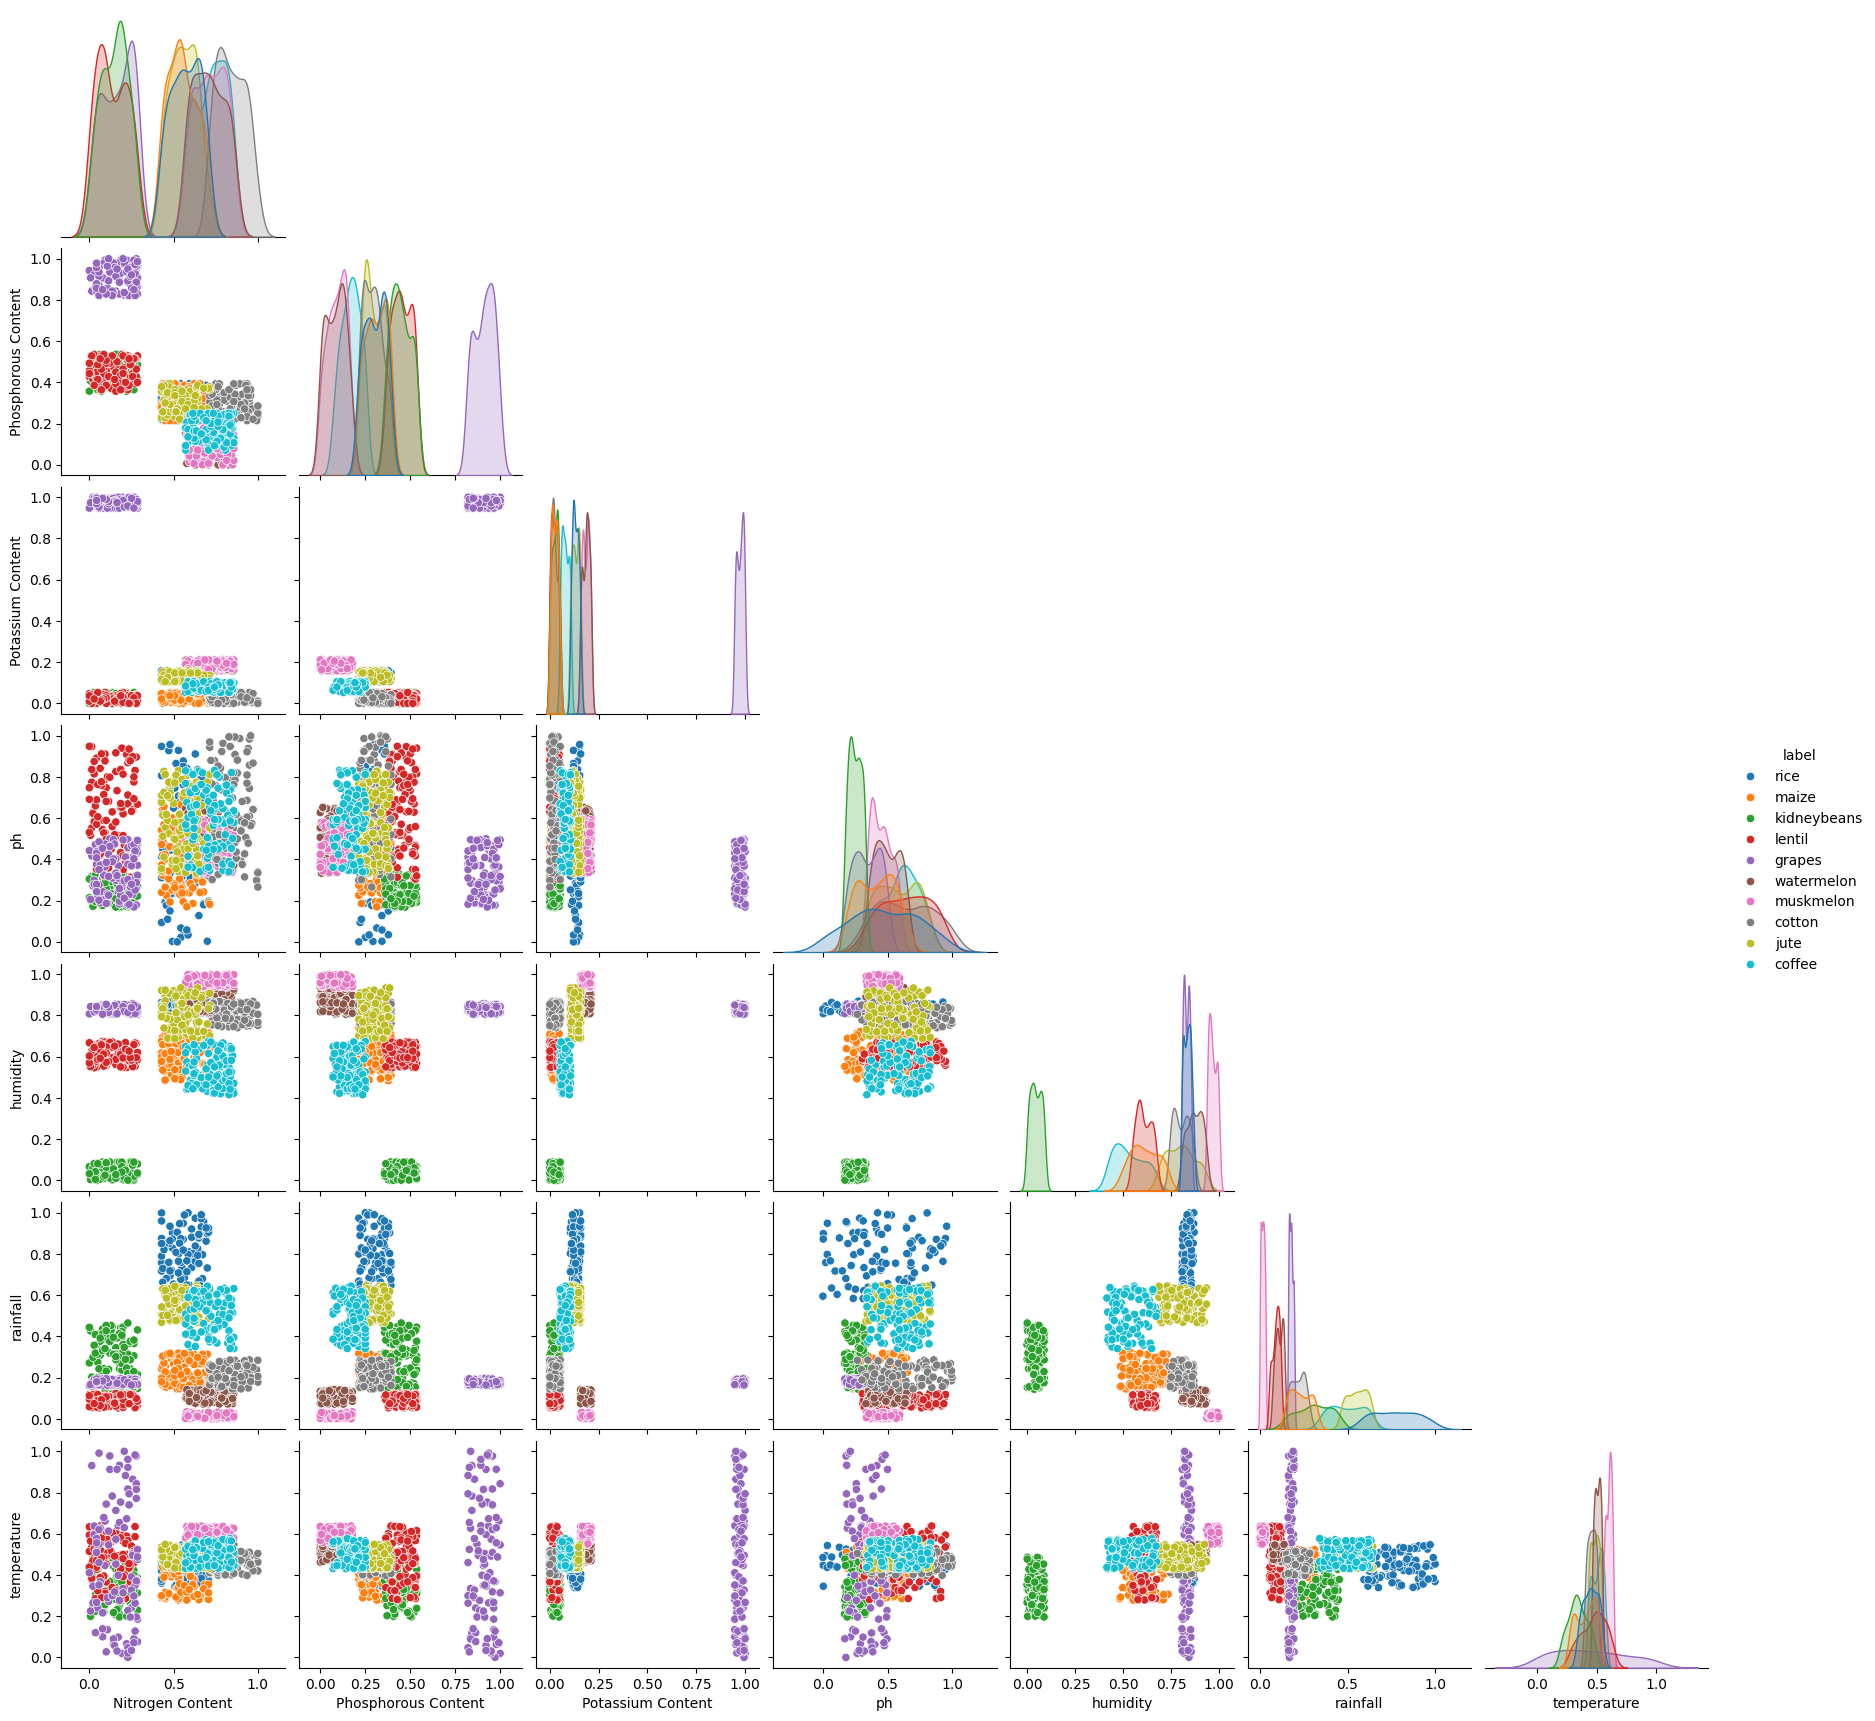

In [43]:
# Feature Relationship with Crops
feature_subset = ["Nitrogen Content", "Phosphorous Content", "Potassium Content", "ph", "humidity", "rainfall", "temperature", "label"]
df_subset = df[feature_subset]
sns.pairplot(df_subset, hue="label", palette="tab10", corner=True)
plt.show()


FEATURE CORRELATION HEATMAP

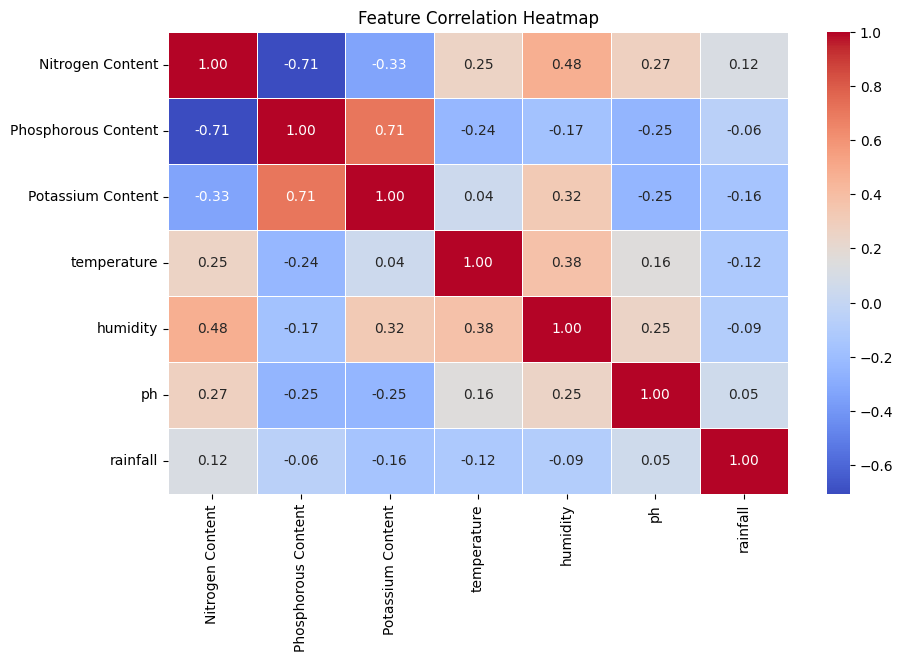

In [33]:
# Compute correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop(columns=["label", "Predicted_Label"]).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()
